In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import stats
from sklearn.model_selection import train_test_split
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import glob,os
# gpu = tf.config.experimental.list_physical_devices(device_type='GPU')
# tf.config.experimental.set_memory_growth(gpu[0], True)
from sklearn.model_selection import KFold

In [3]:
TIME_STEPS=1
FEATURES =6
RANDOM_SEED = 42
step=1
segments=[]

labels=[]
labels_number=[]

In [5]:
filepath="E:/Fall_Detection/Cogent/data/falls/subject_1"
df = pd.read_csv(filepath)
#df['annotation_1'] = df['annotation_1'].replace(2, 1)
# 删除annotation_1列包含数字2的行
df = df[~df['annotation_1'].isin([2])]
#调整df的标号
df.reset_index(drop=True, inplace=True)
i = 0
start_list=[]#统计所有跌倒的开始点
end_list=[]#统计所有跌倒的结束
while (i < len(df)):
    if (df['annotation_1'][i] == 1.0):  # 一次跌倒发生的开始
        start_fall_index = i  # 一次跌倒发生的开始点
        end = i + 1
        while ((0.0 in list(df['annotation_1'][start_fall_index:end])) == False):
            i = i + 1
            end = i
        end_fall_index = end - 2
        start_list.append(start_fall_index)
        end_list.append(end_fall_index)
        # 找到峰值所在的坐标
        max_id = df['ch_accel_x'][start_fall_index:end_fall_index + 1].idxmax()
        print(start_fall_index, end_fall_index, df['ch_accel_x'][start_fall_index:end_fall_index + 1].max(),
              df['ch_accel_x'][start_fall_index:end_fall_index + 1].idxmax())  # end_fall_index 一次跌倒发生的结束点
        # 选取峰值附近的数据，假设跌倒发生在2s内，就让max_id向左向右的100个数据注释不变。
        j = start_fall_index
        while (j < max_id - 50):
            df['annotation_1'][j] = 0.0
            j = j + 1
        k = end_fall_index
        while (k > max_id + 50):
            df['annotation_1'][k] = 0.0
            k = k - 1
    else:
        i = i + 1

scale_columns = ['ch_accel_x','ch_accel_y','ch_accel_z','ch_gyro_x','ch_gyro_y','ch_gyro_z']
# 归一化，映射到-1到1之间
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(df[scale_columns])
df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
for i in range (0,len(df)-TIME_STEPS,step):
    x = df['ch_accel_x'].values[i:i + TIME_STEPS].reshape(-1, 1)
    y = df['ch_accel_y'].values[i:i + TIME_STEPS].reshape(-1, 1)
    z = df['ch_accel_z'].values[i:i + TIME_STEPS].reshape(-1, 1)
    xs = df['ch_gyro_x'].values[i:i + TIME_STEPS].reshape(-1, 1)
    ys = df['ch_gyro_y'].values[i:i + TIME_STEPS].reshape(-1, 1)
    zs = df['ch_gyro_z'].values[i:i + TIME_STEPS].reshape(-1, 1)
    label = stats.mode(df['annotation_1'][i:i + TIME_STEPS])[0][0]  # 出现最多的类别
    label_number = stats.mode(df['annotation_1'][i:i + TIME_STEPS])[1][0]  # 出现最多的类别的个数
    segments.append(np.hstack((x,y,z,xs, ys, zs)))
    labels.append(label)
    labels_number.append(label_number)

2358 3039 1.4863 2867
10889 11420 5.847 11374


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_12028/2072058878.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['annotation_1'][j] = 0.0
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_12028/2072058878.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['annotation_1'][k] = 0.0


28535 29347 5.8525 28964
53883 55063 2.97 54438
61650 62290 3.5137 62179
69125 71066 2.194 69799
80528 81469 5.0656 81112
88904 89643 2.8006 89312
100677 101441 5.6612 101187
116277 116886 3.6612 116743
141158 141711 5.8552 141642
147747 148450 2.2049 148173
153680 154856 2.1639 154260
159777 160647 5.8552 160396


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


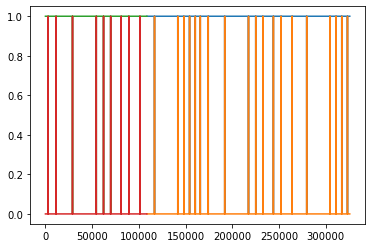

-------------load the model-----------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                137536    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 137,666
Trainable params: 137,666
Non-trainable params: 0
_________________________________________________________________
3394/3394 [==============================] - 11s 3ms/step - loss: 207566.7969 - acc: 0.9917


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_12028/2399253946.py:86: RuntimeWarning: invalid value encountered in longlong_scalars
  Precision.append(tp / (tp + fp))


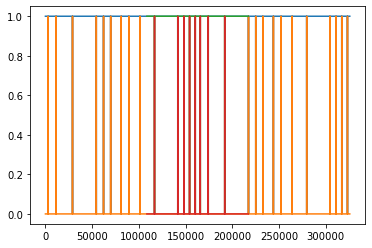

-------------load the model-----------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_1 (TCN)                 (None, 64)                137536    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 137,666
Trainable params: 137,666
Non-trainable params: 0
_________________________________________________________________
3394/3394 [==============================] - 12s 3ms/step - loss: 652291.5000 - acc: 0.9926


In [ ]:
floder = KFold(n_splits=3,shuffle=False)
reshaped_segments =np.asarray(segments,dtype=np.float32).reshape(-1,TIME_STEPS,FEATURES)
labels=np.asarray(pd.get_dummies(labels),dtype=np.float32)#是利用pandas实现one hot encode的方式。
LOSS=[]
ACC=[]
TN=[]
FP=[]
FN=[]
TP=[]
Accuracy=[]
Precision=[]
Recall=[]
k_fold_num=0
for train_index, test_index in floder.split(reshaped_segments):
    k_fold_num +=1
    X_train, X_test = reshaped_segments[train_index], reshaped_segments[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    plt.plot(train_index,y_train)
    plt.plot(test_index,y_test)
    plt.show()
    #------------------------TCN--------------------------
    model_TCN = tf.keras.models.Sequential([
        TCN(input_shape=(X_train.shape[1],X_train.shape[2]),dilations=(1, 2,4,8,16,32)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
    ])
    #---------------------model.compile--------------------------------------------------
    model_TCN.compile(loss='binary_crossentropy',metrics=['acc'],optimizer='adam')
    if(k_fold_num==1):
        checkpoint_save_path1 ="E:/Fall_Detection/Cogent/checkpoint/TCN_cogent1.ckpt"
        if os.path.exists(checkpoint_save_path1 + '.index'):
            print('-------------load the model-----------------')
            model_TCN.load_weights(checkpoint_save_path1)
    if(k_fold_num==2):
        checkpoint_save_path1 ="E:/Fall_Detection/Cogent/checkpoint/TCN_cogent2.ckpt"
        if os.path.exists(checkpoint_save_path1 + '.index'):
            print('-------------load the model-----------------')
            model_TCN.load_weights(checkpoint_save_path1)
    if(k_fold_num==3):
        checkpoint_save_path1 = "E:/Fall_Detection/Cogent/checkpoint/TCN_cogent3.ckpt"
        if os.path.exists(checkpoint_save_path1 + '.index'):
            print('-------------load the model-----------------')
            model_TCN.load_weights(checkpoint_save_path1)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_save_path1,
        save_weights_only=True,
        monitor='acc',
        mode='max',
        save_best_only=True)
   # history_TCN=model_TCN.fit(X_train, y_train, epochs=32, batch_size=64, verbose=1,shuffle=True,callbacks=[model_checkpoint_callback])
    model_TCN.summary()
    loss1, acc1 = model_TCN.evaluate(X_test, y_test, verbose=1)
    LOSS.append(loss1)
    ACC.append(acc1)
    y_pred_label=np.argmax(model_TCN.predict(X_test), axis=1)
    y_test_label=np.argmax(y_test, axis=1)
    #混淆矩阵
    # C=confusion_matrix(y_test_label, y_pred_label)
    # sns.heatmap(C, annot=True)
    confusion_mat= confusion_matrix(y_test_label, y_pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['ADL', 'Fall'])
    disp.plot(
        include_values=True,  # 混淆矩阵每个单元格上显示具体数值
        cmap=plt.cm.Blues,
        ax=None,  # 同上
        xticks_rotation="horizontal",  # 同上
        values_format="d"  # 显示的数值格式
    )
    title = "Confusion matrix"
    disp.ax_.set_title(title)
    if(k_fold_num==1):
        plt.savefig('E:/Fall_Detection/Cogent/figure/k1-TCN-C.png',bbox_inches='tight')
    if(k_fold_num==2):
        plt.savefig('E:/Fall_Detection/Cogent/figure/k2-TCN-C.png',bbox_inches='tight')
    if(k_fold_num==3):
        plt.savefig('E:/Fall_Detection/Cogent/figure/k3-TCN-C.png',bbox_inches='tight')
    plt.close()
    # tn:将ADL预测为ADL  tp:将跌倒预测为跌倒  fp:将ADL预测为跌倒 1 fn：将跌倒预测为ADL
    tn, fp, fn, tp = confusion_matrix(y_test_label, y_pred_label).ravel()
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append((tp + tn) / (tp + tn + fp + fn))
    Precision.append(tp / (tp + fp))
    Recall.append(tp / (tp + fn))
    